In [2]:
import os
from pathlib import Path

from scripts.renv_utils import activate_renv
from var_es_toolbox.data import load_data

activate_renv()
from rpy2.robjects import pandas2ri, globalenv
%load_ext rpy2.ipython

- renv activated -- please restart the R session.


C:\Users\chris\Anaconda\envs\var-es-010\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
project_dir = Path(os.getcwd()).resolve().parent
# Asset
asset = "DBc1_return"
globalenv["asset"] = str(asset)

# Retrieve data
data_dir = project_dir / "data"
data_cleaned_name = "refinitiv_data_merged.csv"
date_format = "ISO8601"
data_cleaned = load_data(data_dir / data_cleaned_name, date_format=date_format)
futures_returns = data_cleaned[asset].dropna()

# Retrieve r model
models_dir = project_dir / "src" / "var_es_toolbox" / "models"
backtest_dir = project_dir / "src" / "var_es_toolbox" / "backtesting"
hs_path = models_dir / "hs.R"
garch_path = models_dir / "garch.R"
gas_path = models_dir / "gas.R"
hybrid_evt_path = models_dir / "hybrid_evt.R"
caviar_path = models_dir / "caviar.R"
backtest_path = backtest_dir / "backtesting.R"

globalenv['hs_path'] = str(hs_path)
globalenv['garch_path'] = str(garch_path)
globalenv['gas_path'] = str(gas_path)
globalenv['hybrid_evt_path'] = str(hybrid_evt_path)
globalenv['caviar_path'] = str(caviar_path)
globalenv['backtest_path'] = str(backtest_path)

# r.source(str(r_arch_models_path))
# r.source(str(r_hybrid_evt_models_path))
# r.source(str(r_non_param_path))
# r.source(str(r_gas_models_path))
# r.source(str(r_caviar_models_path))

c = 0.05
t = 0.95
p = 1
q = 1
m = 1000
n = 200
refit = 10

globalenv['df'] = pandas2ri.py2rpy(futures_returns.reset_index())
globalenv['df_all'] = pandas2ri.py2rpy(data_cleaned.reset_index())
globalenv['c'] = c
globalenv['p'] = p
globalenv['q'] = q
globalenv['m'] = m
globalenv['n'] = n
globalenv['refit'] = refit

In [4]:
%%R
library(xts)
library(rugarch)
library(psych)
library(ggplot2)             

names(df)[names(df) == asset] <- "Return"
dates <- tail(df$Date, n)
returns <- xts(tail(df$Return, n), order.by = dates)

desc_stat <- psych::describe(df_all)
print(desc_stat)

# Define the function for plotting returns, VaR, and ES
plot_var_es <- function(dates, returns, var, es) {
  # Create a data frame for plotting
  plot_data <- data.frame(
    Date = dates,
    Return = returns,
    VaR = var,
    ES = es
  )
  
  # Generate the plot using ggplot2 with labels
  ggplot(plot_data, aes(x = Date)) +
    geom_line(aes(y = Return, color = "Return"), linewidth = 0.7, alpha = 0.8) +    # Actual returns
    geom_line(aes(y = VaR, color = "VaR"), linetype = "dashed", linewidth = 0.7) + # VaR
    geom_line(aes(y = ES, color = "ES"), linetype = "dotted", linewidth = 0.7) +   # ES
    ggtitle("Actual Returns vs. VaR and ES") +
    xlab("Date") +
    ylab("Returns / VaR / ES") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5),
      legend.position = "top"
    ) +
    scale_color_manual(values = c("Return" = "blue", "VaR" = "red", "ES" = "darkorange")) +
    scale_y_continuous(labels = scales::percent) +
    labs(color = "Legend")
}

                         vars    n    mean     sd  median trimmed    mad    min
Date                        1 2876     NaN     NA      NA     NaN     NA    Inf
DBc1                        2 1423  107.77 100.52   77.98   87.17  55.63   2.44
DBc1_return                 3 1423    0.00   0.34    0.00    0.00   0.19  -2.43
DPc1                        4 1420  112.94 106.51   78.10   91.18  55.29   0.01
DPc1_return                 5 1419    0.00   0.51    0.00    0.00   0.23  -7.70
DEBMc1                      6 1923   84.83  78.94   54.37   67.64  32.88  15.74
DEBMc1_return               7 1922    0.00   0.05    0.00    0.00   0.02  -0.50
DEPMc1                      8 1922   97.47  90.71   61.61   77.28  33.77  13.82
DEPMc1_return               9 1921    0.00   0.05    0.00    0.00   0.02  -0.41
DEBQc1                     10 1921  104.73 114.74   56.63   77.48  33.98  19.99
DEBQc1_return              11 1920    0.00   0.04    0.00    0.00   0.02  -0.44
DEPQc1                     12 1923  128.

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma

Keep up to date with changes at https://tidyverse.org/blog/

Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

In addition: Warning messages:
1: package 'psych' was built under R version 4.4.2 
2: In FUN(newX[, i], ...) : no non-missing arguments to min; returning Inf
3: In FUN(newX[, i], ...) :
  no non-missing arguments to max; returning -Inf


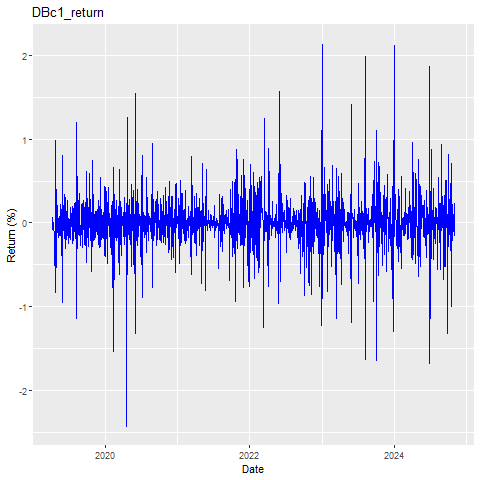

In [9]:
%%R

gg <- ggplot(df, aes(x=Date, y=Return)) +
    geom_line(color="blue") +
    ggtitle(asset) +
    xlab("Date") +
    ylab("Return (%)")
print(gg)

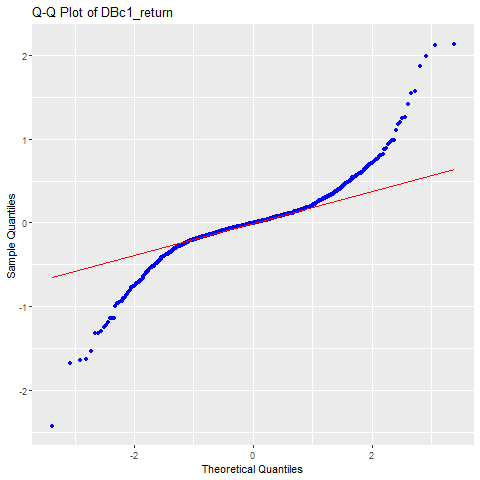

In [10]:
%%R

gg <- ggplot(df, aes(sample = Return)) +
    stat_qq(color = "blue") +
    stat_qq_line(color = "red") +
    ggtitle(paste("Q-Q Plot of", asset)) +
    xlab("Theoretical Quantiles") +
    ylab("Sample Quantiles")
print(gg)

NULL



Calculations completed.



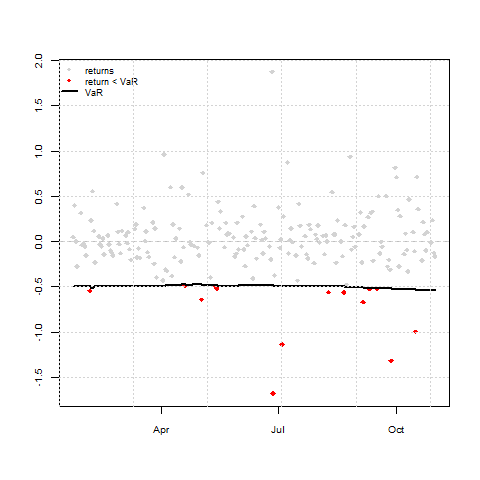

In [12]:
%%R
source(hs_path)

result <- forecast_u_HS(df, c, n, m)

var <- -result$VaR
print(VaRplot(c, returns, var))

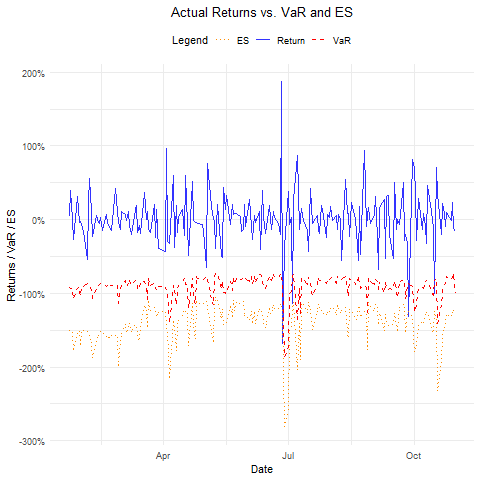

In [32]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [14]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, prefix = "HS")

   ExpectedExceedances ActualExceedances        UC        CC    ER     ER_2
HS                  10                14 0.2197458 0.4708818 0.043 0.707804
         CoC      ESR1    ESR2      ESR3
HS 0.4905756 0.3886074 0.63023 0.8175783



Calculations completed.



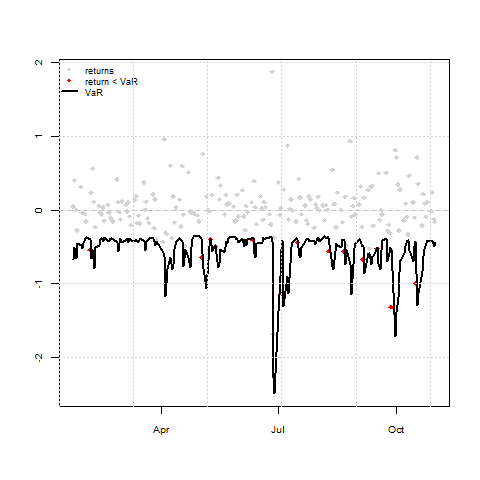

In [33]:
%%R

result <- forecast_u_FHS_GARCH(df, c, n, m)

var <- -result$VaR
VaRplot(c, returns, var)

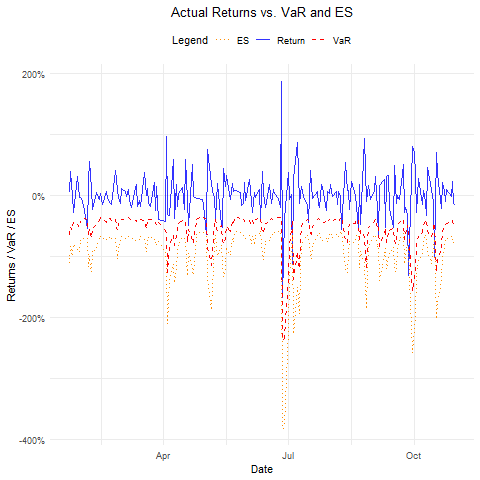

In [16]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [17]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, VOL = vol, prefix = "FHS")

    ExpectedExceedances ActualExceedances        UC       CC    ER      ER_2
FHS                  10                11 0.7493283 0.499058 0.053 0.5024843
          CoC       ESR1       ESR2      ESR3
FHS 0.8751198 0.07832677 0.02105686 0.6633425


NULL


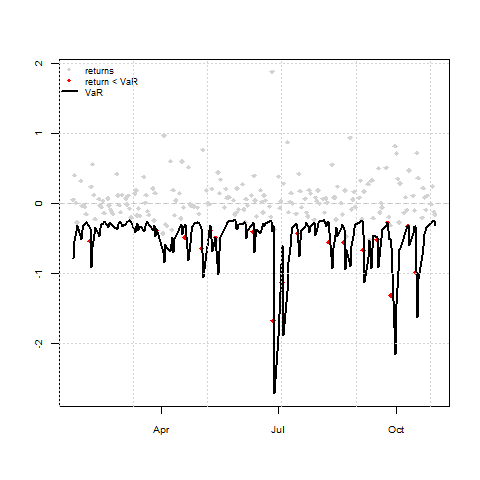

In [18]:
%%R
source(garch_path)

result <- forecast_u_GARCH(df, c, n, m, r = 100, model = "gjrGARCH", dist = "sstd")

var <- -result$VaR
print(VaRplot(c, returns, var))

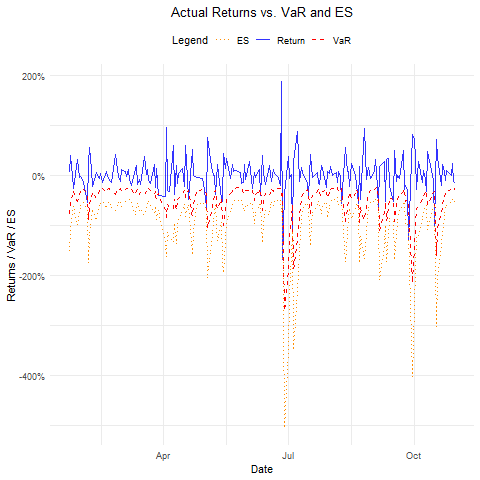

In [19]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [20]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, VOL = vol, prefix = "GJR-GARCH")

          ExpectedExceedances ActualExceedances         UC         CC ER
GJR-GARCH                  10                18 0.01899483 0.01063066  0
               ER_2       CoC       ESR1      ESR2      ESR3
GJR-GARCH 0.7898948 0.5259376 0.08778102 0.4009206 0.7137109


NULL



Attaching package: 'GAS'

The following objects are masked from 'package:rugarch':

    convergence, pit, residuals

The following object is masked from 'package:stats':

    residuals

In addition: Warning message:
package 'GAS' was built under R version 4.4.2 


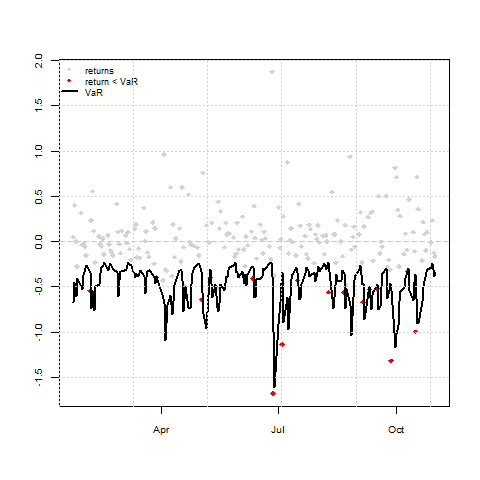

In [21]:
%%R
source(gas_path)

result <- forecast_u_GAS(df, c, n, m, r = 100, dist = "sstd")

var <- -result$VaR
VaRplot(c, returns, var)

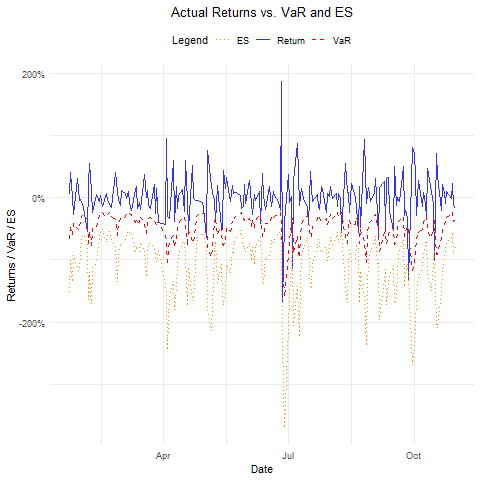

In [22]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [35]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, prefix = "GAS")

Warning messages:
1: package 'DEoptim' was built under R version 4.4.2
2: In log((c - 1)/ES) : NaNs produced
3: In log((c - 1)/ES) : NaNs produced
4: In log((c - 1)/ES) : NaNs produced
5: In log((c - 1)/ES) : NaNs produced
6: In log((c - 1)/ES) : NaNs produced
7: In log((c - 1)/ES) : NaNs produced
8: In log((c - 1)/ES) : NaNs produced
9: In log((c - 1)/ES) : NaNs produced
10: In log((c - 1)/ES) : NaNs produced
11: In log((c - 1)/ES) : NaNs produced
12: In log((c - 1)/ES) : NaNs produced
13: In log((c - 1)/ES) : NaNs produced
14: In log((c - 1)/ES) : NaNs produced
15: In log((c - 1)/ES) : NaNs produced
16: In log((c - 1)/ES) : NaNs produced
17: In log((c - 1)/ES) : NaNs produced
18: In log((c - 1)/ES) : NaNs produced
19: In log((c - 1)/ES) : NaNs produced
20: In log((c - 1)/ES) : NaNs produced
21: In log((c - 1)/ES) : NaNs produced
22: In log((c - 1)/ES) : NaNs produced
23: In log((c - 1)/ES) : NaNs produced
24: In log((c - 1)/ES) : NaNs produced
25: In log((c - 1)/ES) : NaNs produced
2


Attaching package: 'evir'

The following object is masked from 'package:ggplot2':

    qplot



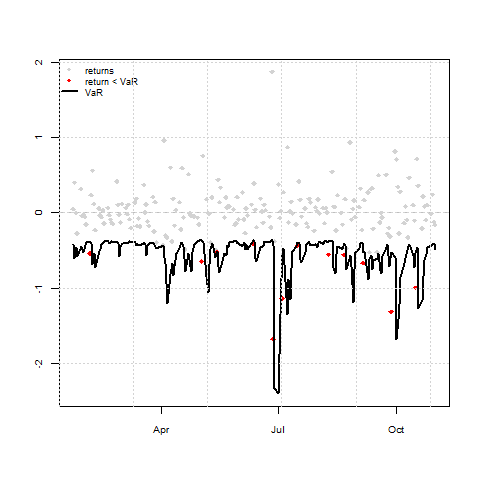

In [21]:
%%R
source(hybrid_evt_path)

result <- forecast_u_EVT_GARCH(df, c, n, m, t = 0.95)

var <- -result$VaR
VaRplot(c, returns, var)

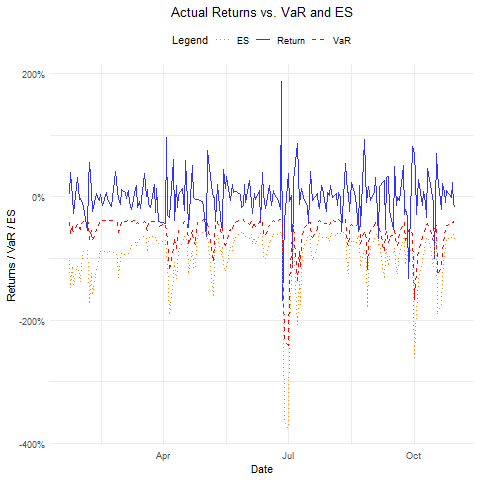

In [25]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [ ]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, VOL = vol, prefix = "EVT_GARCH")

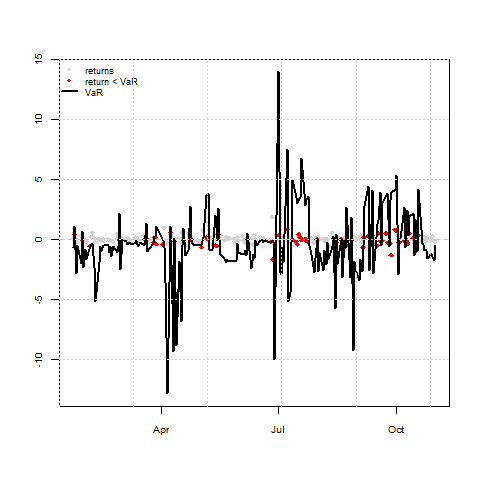

In [37]:
%%R
source(caviar_path)

result <- forecast_u_CAViaR(df, c, n, m, r = 10, var_model = "asymmetricSlope", itermax = 50, es_model="mult")

var <- -result$VaR
VaRplot(c, returns, var)

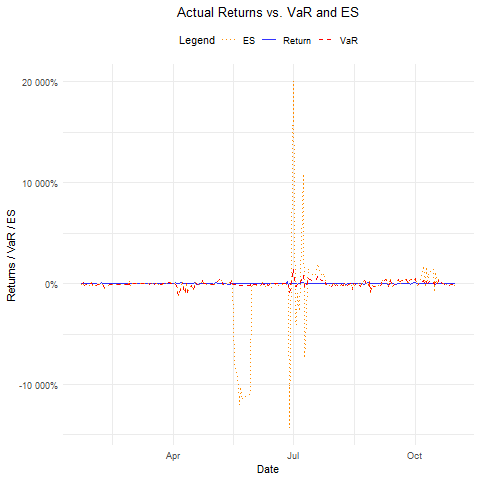

In [38]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [39]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, prefix = "CAVIAR")

       ExpectedExceedances ActualExceedances UC CC ER        ER_2          CoC
CAVIAR                  10                66  0  0  0 0.007034718 1.170397e-12
       ESR1 ESR2      ESR3
CAVIAR    0    0 0.6764859
